In [ ]:
!pip install google-cloud-storage
!pip install pandas

In [1]:
import numpy as np
import pandas as pd

### keep only quality_index_6 >= 0

In [2]:
df_merge_quality = pd.read_csv('US_patent_abstract_5000_2015_with_title_1.csv')
df_merge_quality.shape

(5000, 30)

In [3]:
max(df_merge_quality['quality_index_4'])

0.9117351596366192

In [4]:
min(df_merge_quality['quality_index_4'])

0.0212197159565581

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

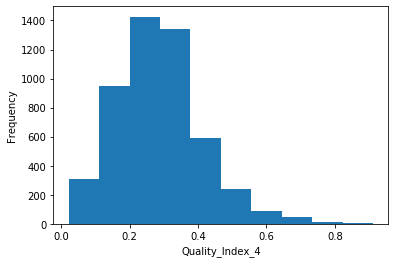

In [6]:
plt.hist(df_merge_quality['quality_index_4'], density=False)  # `density=False` would make counts
plt.ylabel('Frequency')
plt.xlabel('Quality_Index_4');

In [7]:
conditions = [

    (df_merge_quality['quality_index_4'] < 0.3),
    (df_merge_quality['quality_index_4'] >= 0.3)
]

choices = ['0', '1']

In [8]:
import numpy as np
df_merge_quality['quality_rank'] = np.select(condlist=conditions, choicelist=choices)

In [9]:
df_merge_quality

,Unnamed: 0,publication_number,application_number,text,filing_date,new_appl_nbr,appln_id,app_nbr,filing,tech_field,...,breakthrough,breakthrough_xy,generality,originality,radicalness,renewal,quality_index_4,quality_index_6,quality_rank,tech_field_big_cat
0,201997,EP-3085354-A1,EP-16167755-A,Provided herein are methods of using gaseous n...,20111215,EP20160167755,451813367,EP20160167755,2011,16.0,...,NaN,NaN,0.000000,0.880658,0.240741,8.0,0.177162,0.167842,0,2
1,27936,EP-2510698-A2,EP-10836203-A,Disclosed is a method and apparatus of encodin...,20101208,EP20100836203,334696626,EP20100836203,2010,2.0,...,NaN,NaN,0.000000,0.690086,0.156627,9.0,0.382812,0.432070,1,0
2,718991,EP-2927353-A2,EP-15162415-A,The invention relates to an air-jet spinning m...,20150402,EP20150162415,438662266,EP20150162415,2015,28.0,...,NaN,NaN,0.000000,NaN,0.000000,3.0,0.304487,0.246568,1,3
3,322964,EP-2731905-A1,EP-12814169-A,A dispensing closure having a closure body and...,20120716,EP20120814169,380483874,EP20120814169,2012,25.0,...,NaN,NaN,NaN,0.744898,0.785714,6.0,0.127407,0.235815,0,3
4,788590,EP-2979831-A1,EP-15178742-A,A slitting apparatus having an anvil cylinder ...,20150728,EP20150178742,443003052,EP20150178742,2015,26.0,...,NaN,NaN,NaN,0.857143,0.392857,3.0,0.338889,0.459559,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,214061,EP-2539441-A1,EP-11704979-A,The present invention relates to a cell cultur...,20110221,EP20110704979,332527837,EP20110704979,2011,15.0,...,NaN,NaN,NaN,0.765306,0.571429,8.0,0.275205,0.231471,0,2
4996,20029,EP-2483785-A2,EP-10822339-A,The present disclosure includes methods and de...,20100920,EP20100822339,333404856,EP20100822339,2010,6.0,...,NaN,NaN,0.408163,0.777778,0.208333,8.0,0.338130,0.322977,1,0
4997,636303,EP-2845982-A2,EP-14184100-A,The present invention relates to a post 1 for ...,20140909,EP20140184100,421699870,EP20140184100,2014,35.0,...,NaN,NaN,NaN,0.639053,0.230769,4.0,0.182051,0.240659,0,4
4998,85513,EP-2470961-A1,EP-10752443-A,Within an area (A 0 ) where of four heads (60 ...,20100824,EP20100752443,323501678,EP20100752443,2010,9.0,...,NaN,NaN,NaN,0.848837,0.639535,8.0,0.381746,0.422516,1,1


### create a model

In [7]:
import numpy as np
import pandas as pd
import pickle as cPickle
from collections import defaultdict
import re

from bs4 import BeautifulSoup

import sys
import os
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

Using TensorFlow backend.


In [45]:
MAX_SENT_LENGTH = 30
MAX_SENTS = 10
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [46]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [47]:
data_train = df_merge_quality.sample(frac=1)

In [48]:
print(data_train.shape)

(5000, 30)


In [49]:
data_train['quality_rank'].value_counts()

0    2896
1    2104
Name: quality_rank, dtype: int64

In [50]:
2896/5000

0.5792

In [51]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/nobu_yamaguchi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [52]:
from nltk import tokenize

abstracts = []
labels = []
texts = []

for idx in range(data_train.text.shape[0]):

    text = clean_str(str(data_train.iloc[idx]['claims_text']))
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    abstracts.append(sentences)
    labels.append(data_train.iloc[idx]['quality_rank'])

In [53]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

In [54]:
data.shape

(5000, 10, 30)

In [55]:
for i, sentences in enumerate(abstracts):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
            #for word in wordTokens:
                if word in tokenizer.word_index.keys():
                    if (k < MAX_SENT_LENGTH) and (tokenizer.word_index[word] < MAX_NB_WORDS):
                        data[i, j, k] = tokenizer.word_index[word]
                        k = k + 1

In [56]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 31722 unique tokens.


In [57]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (5000, 10, 30)
Shape of label tensor: (5000, 2)


In [58]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

In [59]:
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [60]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [61]:
print('Number of positive and negative reviews in traing and validation set')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))

Number of positive and negative reviews in traing and validation set
[2323. 1677.]
[573. 427.]


In [62]:
# Standard python helper libraries.
import os, sys, re, json, time
import itertools, collections
from importlib import reload
from IPython.display import display

# NumPy and SciPy for matrix ops

import scipy.sparse


# Helper libraries
#from w266_common import utils, vocabulary, tf_embed_viz
#import glove_helper; reload(glove_helper)

#hands = glove_helper.Hands(ndim=100)  # 50, 100, 200, 300 dim are available

import zipfile
with zipfile.ZipFile("data/glove/glove.6B.zip", 'r') as zip_ref:
    zip_ref.extractall("data/glove")

In [63]:
GLOVE_DIR = "data/glove"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [64]:
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [65]:
# building Hierachical Attention network
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,
                            trainable=False)

In [66]:
class AttLayer(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(AttLayer, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)), name='W')
        self.b = K.variable(self.init((self.attention_dim, )), name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)), name='u')
        self.trainable_weights = [self.W, self.b, self.u]
        super(AttLayer, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
 
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b)) #

        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)

        ait = K.exp(ait)


        #if mask is not None:
        #    # Cast the mask to floatX to avoid float64 upcasting in theano
        #    print('mask')
        #    ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        ait = K.expand_dims(ait)
 
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [67]:
sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
l_att = AttLayer(100)(l_lstm)
sentEncoder = Model(sentence_input, l_att)

tracking <tf.Variable 'att_layer_5/W:0' shape=(200, 100) dtype=float32> W
tracking <tf.Variable 'att_layer_5/b:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'att_layer_5/u:0' shape=(100, 1) dtype=float32> u


In [68]:
abstract_input = Input(shape=(MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
abstract_encoder = TimeDistributed(sentEncoder)(abstract_input)
l_lstm_sent = Bidirectional(GRU(30, return_sequences=True))(abstract_encoder)

In [50]:
abstract_input.shape

TensorShape([None, 3, 30])

In [51]:
abstract_encoder.shape

TensorShape([None, 3, 200])

In [52]:
l_lstm_sent.shape

TensorShape([None, 3, 60])

In [69]:
#l_att_sent = AttLayer(100)(l_lstm_sent)
l_att_sent = AttLayer(100)(l_lstm_sent)

tracking <tf.Variable 'att_layer_6/W:0' shape=(60, 100) dtype=float32> W
tracking <tf.Variable 'att_layer_6/b:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'att_layer_6/u:0' shape=(100, 1) dtype=float32> u


In [70]:
l_att_dense = Dense(100, activation='relu')(l_att_sent)
l_att_dense = Dense(100, activation='relu')(l_att_dense)
l_att_dense = Dense(100, activation='relu')(l_att_dense)
l_att_sent_drop = Dropout(rate=0.3)(l_att_dense)
preds = Dense(2, activation='sigmoid')(l_att_sent_drop)
model = Model(abstract_input, preds)

In [42]:
preds.shape

TensorShape([None, 2])

In [71]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [44]:
print("model fitting - Hierachical attention network 0.3")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=10, batch_size=50)

model fitting - Hierachical attention network 0.3


/home/nobu_yamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 14s 4ms/step - loss: 0.6817 - acc: 0.5739 - val_loss: 0.6860 - val_acc: 0.5640
Epoch 2/10
4000/4000 [==============================] - 11s 3ms/step - loss: 0.6767 - acc: 0.5831 - val_loss: 0.6846 - val_acc: 0.5640
Epoch 3/10
4000/4000 [==============================] - 11s 3ms/step - loss: 0.6757 - acc: 0.5825 - val_loss: 0.6838 - val_acc: 0.5650
Epoch 4/10
4000/4000 [==============================] - 11s 3ms/step - loss: 0.6718 - acc: 0.5804 - val_loss: 0.6839 - val_acc: 0.5675
Epoch 5/10
4000/4000 [==============================] - 11s 3ms/step - loss: 0.6601 - acc: 0.6060 - val_loss: 0.6884 - val_acc: 0.5385
Epoch 6/10
4000/4000 [==============================] - 11s 3ms/step - loss: 0.6471 - acc: 0.6164 - val_loss: 0.6821 - val_acc: 0.5445
Epoch 7/10
4000/4000 [==============================] - 11s 3ms/step - loss: 0.6333 - acc: 0.6395 - val_loss: 0.6862 - val_acc: 0.5665
Epoch 8

### We changed max_sentence to 10

In [72]:
print("model fitting - Hierachical attention network - 0.3 Max sentence = 10")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=10, batch_size=50)

model fitting - Hierachical attention network - 0.3 Max sentence = 6


/home/nobu_yamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 32s 8ms/step - loss: 0.6586 - acc: 0.5811 - val_loss: 0.6518 - val_acc: 0.5730
Epoch 2/10
4000/4000 [==============================] - 27s 7ms/step - loss: 0.6520 - acc: 0.5786 - val_loss: 0.6519 - val_acc: 0.5845
Epoch 3/10
4000/4000 [==============================] - 27s 7ms/step - loss: 0.6512 - acc: 0.5895 - val_loss: 0.6475 - val_acc: 0.6060
Epoch 4/10
4000/4000 [==============================] - 28s 7ms/step - loss: 0.6464 - acc: 0.6056 - val_loss: 0.6496 - val_acc: 0.5830
Epoch 5/10
4000/4000 [==============================] - 28s 7ms/step - loss: 0.6381 - acc: 0.6302 - val_loss: 0.6447 - val_acc: 0.6110
Epoch 6/10
4000/4000 [==============================] - 28s 7ms/step - loss: 0.6363 - acc: 0.6341 - val_loss: 0.6381 - val_acc: 0.6320
Epoch 7/10
4000/4000 [==============================] - 27s 7ms/step - loss: 0.6231 - acc: 0.6515 - val_loss: 0.6368 - val_acc: 0.6300
Epoch 8

In [56]:
print("model fitting - Hierachical attention network  .3")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=5, batch_size=50)

model fitting - Hierachical attention network  .3


/home/nobu_yamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 13s 3ms/step - loss: 0.6465 - acc: 0.6551 - val_loss: 0.6522 - val_acc: 0.6390
Epoch 2/5
4000/4000 [==============================] - 10s 2ms/step - loss: 0.6405 - acc: 0.6610 - val_loss: 0.6508 - val_acc: 0.6390
Epoch 3/5
4000/4000 [==============================] - 10s 2ms/step - loss: 0.6377 - acc: 0.6611 - val_loss: 0.6483 - val_acc: 0.6390
Epoch 4/5
4000/4000 [==============================] - 9s 2ms/step - loss: 0.6330 - acc: 0.6599 - val_loss: 0.6472 - val_acc: 0.6370
Epoch 5/5
4000/4000 [==============================] - 10s 2ms/step - loss: 0.6250 - acc: 0.6629 - val_loss: 0.6455 - val_acc: 0.6395
